# Custom Models and Likelihoods

By fitting a basic lightcurve model with a radial velocity model, we demonstrate how to build custom models and likelihoods in RadVel versions 1.40 and later. Note that this is different from previous versions, now that parameters are stored in a ``radvel.Vector`` object.


Perform some preliminary imports:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize

import corner

import radvel
import radvel.likelihood

import batman

matplotlib.rcParams['font.size'] = 14

We begin by generating artifical transit data using the [`batman`](https://www.cfa.harvard.edu/~lkreidberg/batman/index.html) package, described in Kreidberg (2015):

In [2]:
x_trans = np.sort(np.random.uniform(low=2456296,high=2456307,size=170))
yerr_trans = 4e-3 #assuming we know the Gaussian uncertainty

p = batman.TransitParams()
p.t0 = 2456301.6
p.per = 200.31
p.rp = .121
p.a = 14.3
p.inc = 89.0
p.ecc = 0.0
p.w = 0
p.limb_dark = 'uniform'
p.u = []

m = batman.TransitModel(p, x_trans)
y_trans = m.light_curve(p)
y_trans += yerr_trans * np.random.randn(len(y_trans))

We can now generate corresponding simulated radial velocities using `radvel`:

In [3]:
x_rv = np.sort(np.random.uniform(low=2456200,high=2457140,size=83))
yerr_rv = 10 #assuming we know the Gaussian uncertainty

synth_params = radvel.Parameters(1,basis='per tc e w k')
synth_params['per1'] = radvel.Parameter(value = 200.31)
synth_params['tc1'] = radvel.Parameter(value = 2456301.6)
synth_params['e1'] = radvel.Parameter(value = 0.0)
synth_params['w1'] = radvel.Parameter(value = 0.0)
synth_params['k1'] = radvel.Parameter(value = 39.1)

synth_params['dvdt'] = radvel.Parameter(value=0)
synth_params['curv'] = radvel.Parameter(value=0)

synth_model = radvel.RVModel(params=synth_params)
y_rv = synth_model(x_rv)
y_rv += yerr_rv * np.random.randn(len(y_rv))                                                           

Now we prepare for the analyis of our data. We can begin by defining the parameters that will be used in our models:

In [4]:
params = radvel.Parameters(num_planets=1)
params['tc'] = radvel.Parameter(value=2456300)
params['per'] = radvel.Parameter(value=200)
params['a'] = radvel.Parameter(value=10)
params['rp'] = radvel.Parameter(value=0.08)
params['inc'] = radvel.Parameter(value=90)
params['e'] = radvel.Parameter(value=0.0, vary=False, linear=False) #for simplicity, we assume a circular orbit
params['w'] = radvel.Parameter(value=0.0, vary=False, linear=False)
params['k'] = radvel.Parameter(value=30)

params['jit_trans'] = radvel.Parameter(value=0.01)
params['gamma_trans'] = radvel.Parameter(value=0, vary=False) #Unless you construct your own likelihood, 
                                                              #you must provide both a gamma and jitter term.
                                                              #Here we fix gamma at 0 because it doesn't contribute
                                                              #to the transit likelihood
params['jit_rv'] = radvel.Parameter(value=1.0)
params['gamma_rv'] = radvel.Parameter(value=0.0)

Next, we need to set up a dictionary that tells RadVel how to construct a `radvel.Vector` object from the `radvel.Parameters` object. Using these indices, the model is then able to quickly read parameter values from the vector. Each index corresponds to a row in the vector, and every parameter used needs to be assigned a unique index.

In [5]:
indices = {
    'tc': 0,
    'per': 1,
    'rp': 2,
    'a': 3,
    'inc': 4,
    'e': 5,
    'w': 6,
    'k': 7,
    'dvdt': 8,
    'curv': 9,
    'jit_trans': 10,
    'gamma_trans':11,
    'jit_rv': 12,
    'gamma_rv': 13
}

Using the indices defined above, we will now provide a function that defines the lightcurve signal as a function of time and parameters:

In [6]:
def lightcurve_calc(t, params, vector):
    
    pars = batman.TransitParams()
    pars.t0 = vector.vector[0][0]
    pars.per = vector.vector[1][0]
    pars.rp = vector.vector[2][0]
    pars.a = vector.vector[3][0]
    pars.inc = vector.vector[4][0]
    pars.ecc = vector.vector[5][0]
    pars.w = vector.vector[6][0]
    pars.limb_dark = "uniform" 
    pars.u = []

    m = batman.TransitModel(pars, t)

    flux = m.light_curve(pars)
    return flux

We now need to use the same indices to define the radial velocities as a function of the time and parameters. We cannot use the default vector construction because there are shared parameters between the transit model and the radial velocity model; they need to pull values from the same vector.

In [7]:
def rv_calc(t, params, vector):
    
    per = vector.vector[1][0]
    tp = radvel.orbit.timetrans_to_timeperi(tc=vector.vector[0][0], per=vector.vector[1][0], 
                                            ecc=vector.vector[5][0], omega=vector.vector[6][0])
    e = vector.vector[5][0]
    w = vector.vector[6][0]
    k = vector.vector[7][0]
    orbel_synth = np.array([per, tp, e, w, k])
    vel = radvel.kepler.rv_drive(t, orbel_synth)
    
    return vel

Using the functions that define our models, we can now construct `radvel.GeneralRVModel` objects. For the first model, we must override the default vector construction by calling `radvel.GeneralRVModel.vector.indices` and `radvel.GeneralRVModel.vector.dict_to_vector()`. For any additional models, we must set the vector equal to  the initial model's vector, that way they are functions of the same parameters.

In [8]:
mod_trans = radvel.GeneralRVModel(params, forward_model=lightcurve_calc)
mod_trans.vector.indices = indices
mod_trans.vector.dict_to_vector()

mod_rv = radvel.GeneralRVModel(params, forward_model=rv_calc)
mod_rv.vector = mod_trans.vector

We can now plot the data and initial models. When using custom parameters and models, built in plotting functions will rarely work.

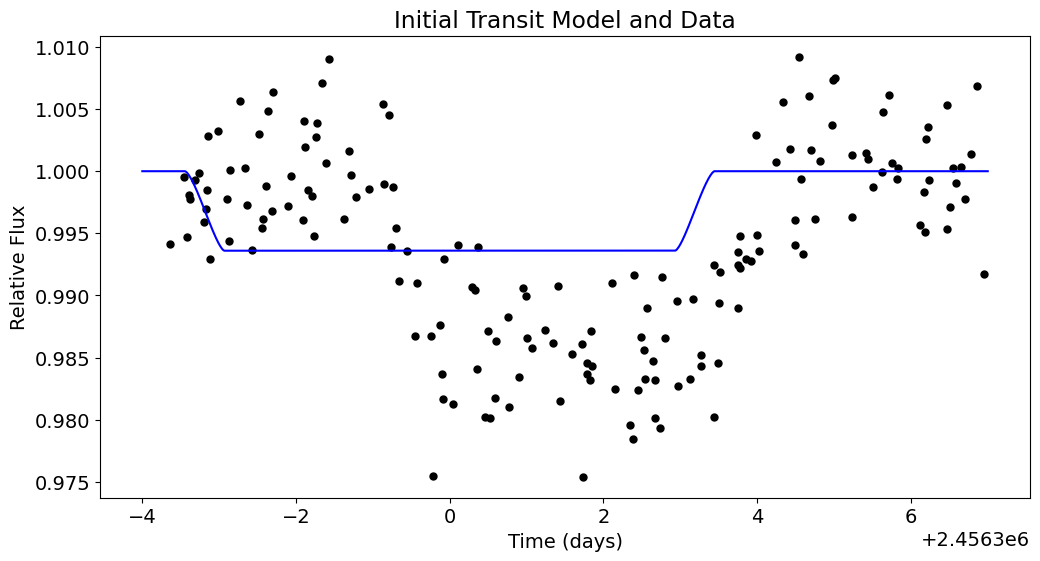

In [9]:
t_trans = np.linspace(2456296, 2456307, 1000)
plt.figure(figsize=(12,6))
plt.scatter(x_trans, y_trans, c='black')
plt.plot(t_trans, mod_trans(t_trans), c='blue')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')
plt.title('Initial Transit Model and Data')
plt.show()

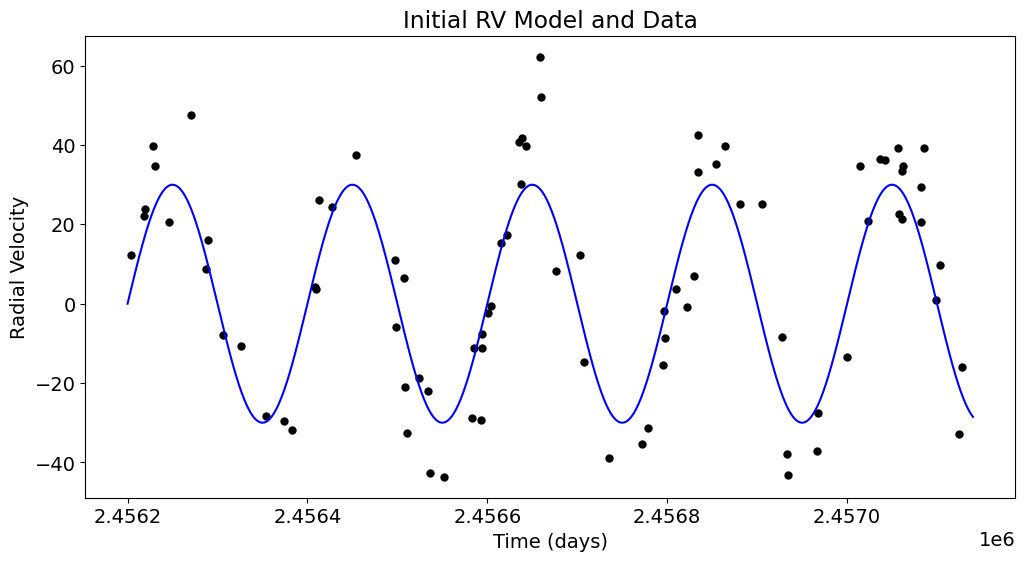

In [10]:
t_rv = np.linspace(2456200, 2457140, 1000)
plt.figure(figsize=(12,6))
plt.scatter(x_rv, y_rv, c='black')
plt.plot(t_rv, mod_rv(t_rv), c='blue')
plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity')
plt.title('Initial RV Model and Data')
plt.show()

Now that the models are ready, we need to set up our likelihood objects. Because we will be using a composite likelihood later on, it is easiest to use the `radvel.RVLikelihood` object. However, building off the generic `radvel.Likelihood` class is an option, allowing you to define your own methods and attributes. 

In [11]:
errors_trans = np.zeros(len(x_trans))
errors_trans.fill(yerr_trans)
like_trans = radvel.RVLikelihood(mod_trans, x_trans, y_trans, errors_trans, suffix='_trans')

errors_rv = np.zeros(len(x_rv))
errors_rv.fill(yerr_rv)
like_rv = radvel.RVLikelihood(mod_rv, x_rv, y_rv, errors_rv, suffix='_rv')

Now that we have our individual likelihoods ready, we need to construct a composite likelihood:

In [12]:
like = radvel.CompositeLikelihood([like_trans, like_rv])

Now we are ready to initialize the `radvel.Posterior` object. Note that most built in priors may be used on custom parameters.

In [13]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.HardBounds('rp',0,1)] #priors are useful to keep params in physically possible boundaries
post.priors += [radvel.prior.HardBounds('a',5,30)]

Maximize the likelihood, print the updated posterior object, and plot the newly fitted model:

In [14]:
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(),
    method='Powell',
    )

print(post)

parameter                     value      vary
tc                       2.4563e+06       True
per                         201.298       True
a                           14.4753       True
rp                         0.120218       True
inc                         90.3734       True
e                                 0      False
w                                 0      False
k                           38.9104       True
jit_trans              -0.000685805       True
gamma_trans                       0      False
jit_rv                      3.06048       True
gamma_rv                  0.0414629       True

Priors
------
Bounded prior on rp, min=0, max=1
Bounded prior on a, min=5, max=30



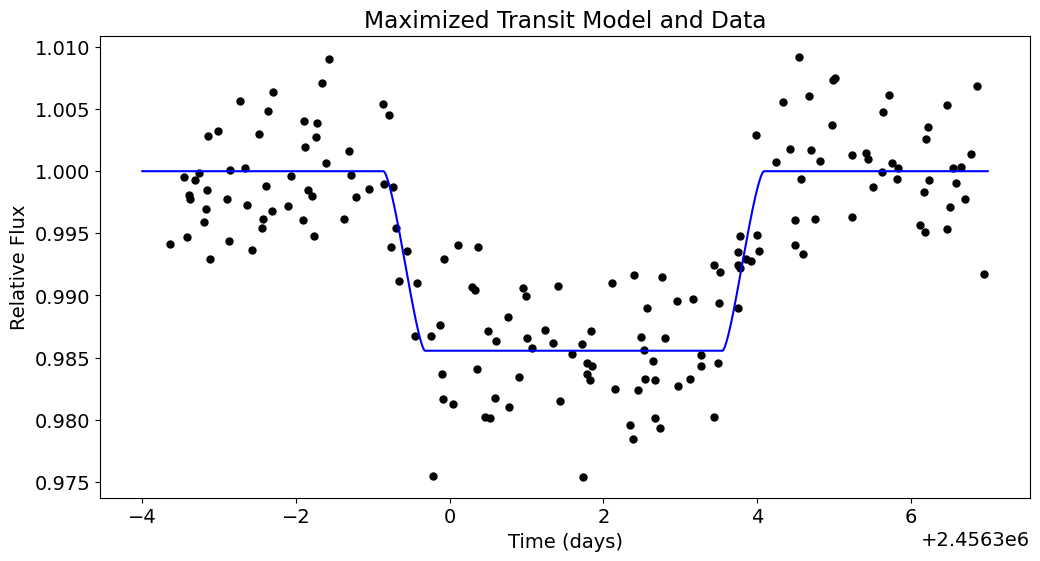

In [15]:
plt.figure(figsize=(12,6))
plt.scatter(x_trans, y_trans, c='black')
plt.plot(t_trans, post.likelihood.like_list[0].model(t_trans), c='blue')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')
plt.title('Maximized Transit Model and Data')
plt.show()

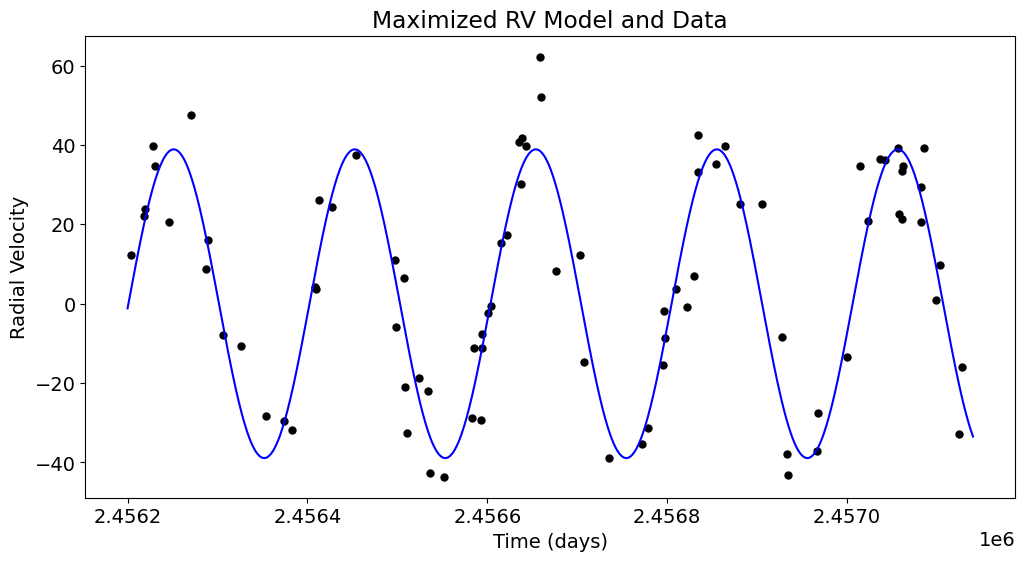

In [16]:
plt.figure(figsize=(12,6))
plt.scatter(x_rv, y_rv, c='black')
plt.plot(t_rv, post.likelihood.like_list[1].model(t_rv), c='blue')
plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity')
plt.title('Maximized RV Model and Data')
plt.show()

Now lets use Markov-Chain Monte Carlo (MCMC) to estimate the parameter uncertainties. In this example we will run 500 steps for the sake of speed but in practice you should let it run at least 10000 steps and ~50 walkers.

In [17]:
df = radvel.mcmc(post,nwalkers=50,nrun=500)

20000/200000 (10.0%) steps complete; Running 25557.02 steps/s; Mean acceptance rate = 36.4%; Min Auto Factor =  18; Max Auto Relative-Change =   inf; Min Tz = 1644.4; Max G-R = 1.017
Discarding burn-in now that the chains are marginally well-mixed

200000/200000 (100.0%) steps complete; Running 25959.06 steps/s; Mean acceptance rate = 20.7%; Min Auto Factor =  16; Max Auto Relative-Change = 0.138; Min Tz = 456.3; Max G-R = 1.068

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


Let's take a quick look at the parameter values and uncertainties. Additionally, we need to update the posterior for future plotting and other purposes.

In [18]:
quants = df.quantile([0.159, 0.5, 0.841]) # median & 1sigma limits of posterior distributions

par_array = []
for par in post.name_vary_params():
    med = quants[par][0.5]
    high = quants[par][0.841] - med
    low = med - quants[par][0.159]
    err = np.mean([high,low])
    err = radvel.utils.round_sig(err)
    par_array.append(med) 
    med, err, errhigh = radvel.utils.sigfig(med, err)
    print('{} : {} +/- {}'.format(par, med, err))
post.set_vary_params(par_array)

tc : 2456301.618 +/- 0.083
per : 201.31 +/- 0.24
rp : 0.121 +/- 0.053
a : 14.0 +/- 1.9
inc : 91 +/- 300
k : 39.0 +/- 2.8
jit_trans : -0.0008 +/- 0.0039
jit_rv : 3 +/- 5
gamma_rv : 0.04 +/- 0.18


Let's make a corner plot to display the posterior distributions:

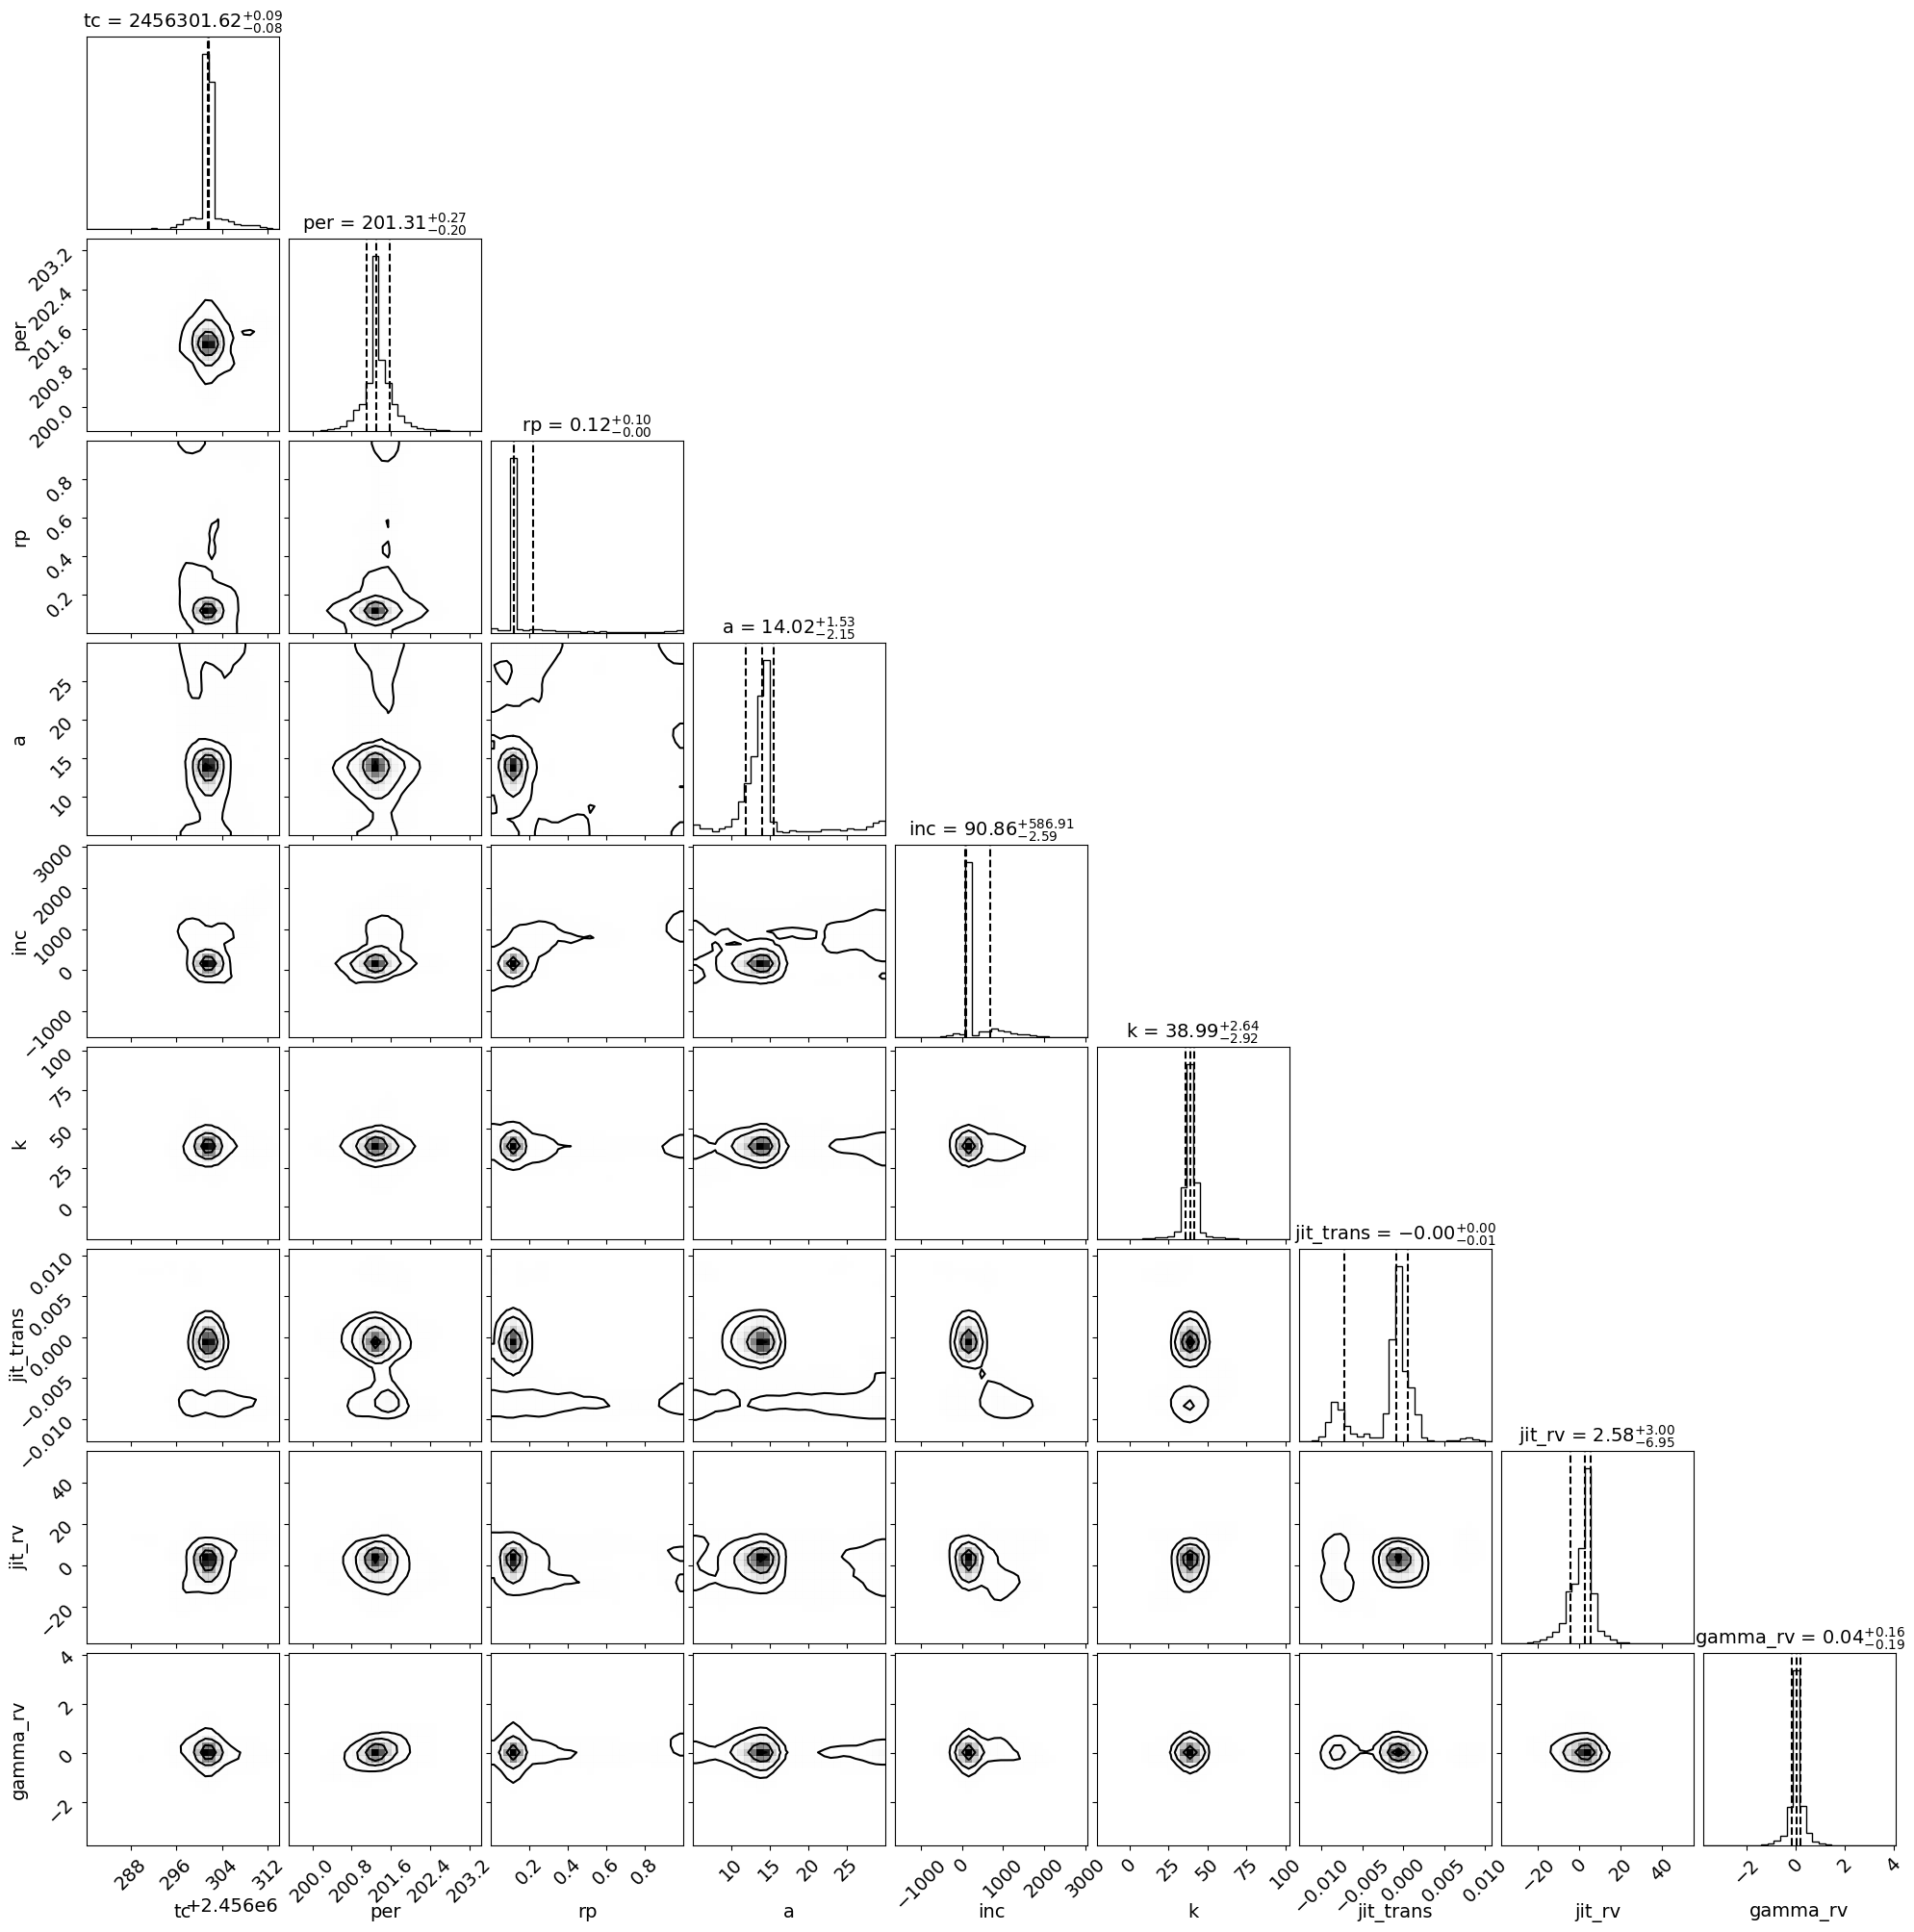

In [19]:
_ = corner.corner(df[post.name_vary_params()], labels=post.name_vary_params(), label_kwargs={"fontsize": 14},
            plot_datapoints=False, bins=30, quantiles=[0.16, 0.5, 0.84],
            show_titles=True, title_kwargs={"fontsize": 14}, smooth=True
        )
plt.show()

Finally, we can plot our MCMC model and data.

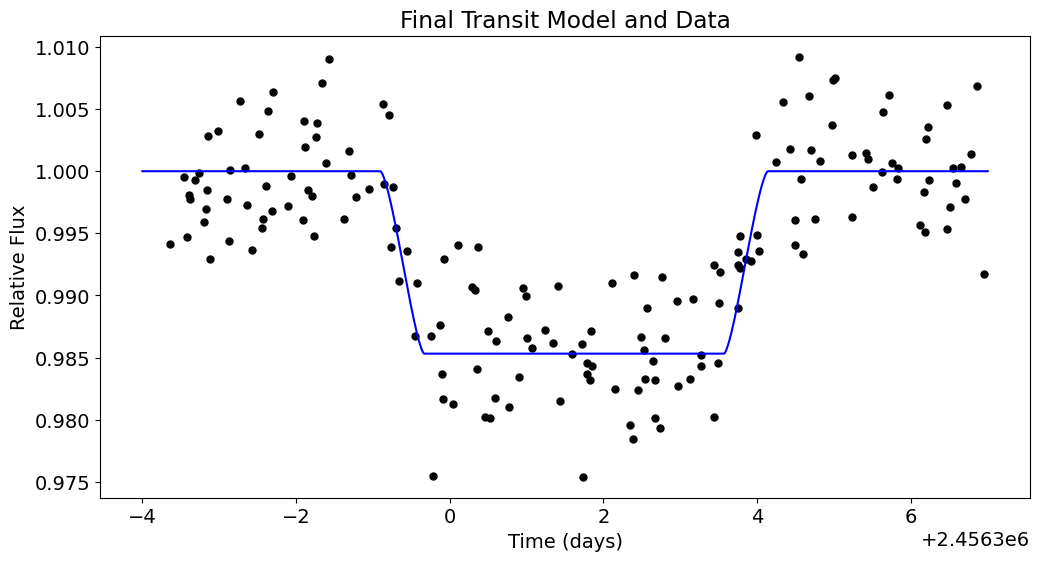

In [20]:
plt.figure(figsize=(12,6))
plt.scatter(x_trans, y_trans, c='black')
plt.plot(t_trans, post.likelihood.like_list[0].model(t_trans), c='blue')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')
plt.title('Final Transit Model and Data')
plt.show()

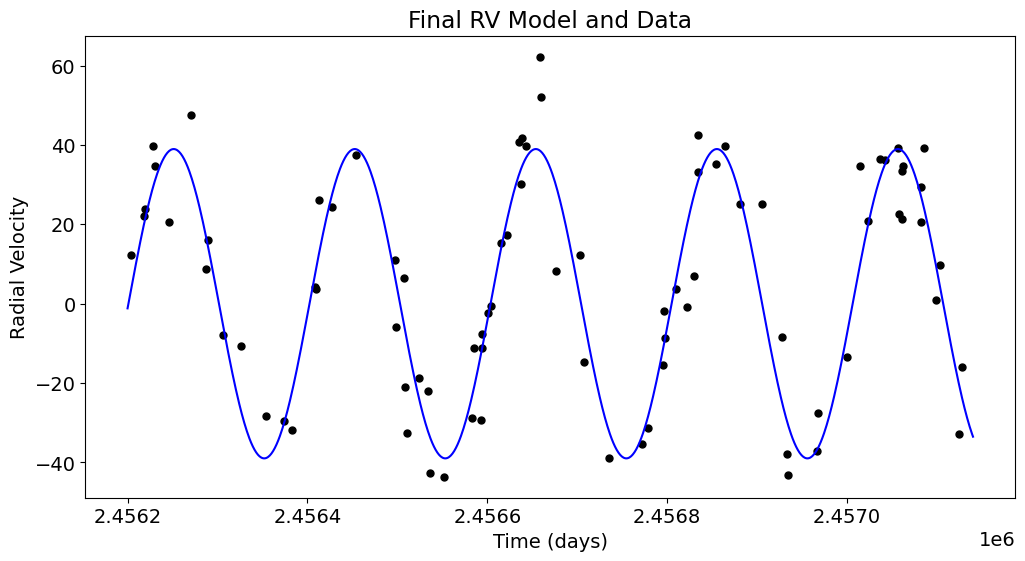

In [21]:
plt.figure(figsize=(12,6))
plt.scatter(x_rv, y_rv, c='black')
plt.plot(t_rv, post.likelihood.like_list[1].model(t_rv), c='blue')
plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity')
plt.title('Final RV Model and Data')
plt.show()